# QC Test Coverage

In our preliminary investigation, it became evident that we didn't yet have enough basic QC tests implemented to cover all the reasons profiles were being flagged in *quota*. Here, we create the infrastructure to quickly assess the coverage of our tests, before returning to the problem of constructing final decisions via machine learning strategies.

 - **AutoQC Version**: `learning-0.0.2`
 - **Datasets**: `quota` (unreleased)
 - **OS**: OSX 10.10.3
 - **Python version**: Python 2.7.10 :: Anaconda 2.3.0 (x86_64); see pip_freeze.dat for package versions.

## 0.1: Data Reduction

The full dataset was processed by AutoQC, and the results logged as JSON serializations.

In [20]:
import json

def reloadData(): 
    ## read raw data
    with open('../../../AutoQC_raw/quota/parallelTest-large/true-quota.dat') as true_data:    
        truth = json.load(true_data)

    with open('../../../AutoQC_raw/quota/parallelTest-large/results-quota.dat') as results_data:    
        rawResults = json.load(results_data)
        
    return truth, rawResults

truth, rawResults = reloadData()
datasetSize = len(truth)
tests = ['Argo_global_range_check','Argo_gradient_test','Argo_impossible_date_test',
         'Argo_impossible_location_test','Argo_pressure_increasing_test',
         'Argo_regional_range_test','Argo_spike_test','EN_background_check',
         'EN_constant_value_check','EN_range_check','EN_spike_and_step_check',
         'EN_stability_check','WOD_gradient_check','WOD_range_check']

## 0.2: Helpers

We repeat some of the helpers from the previous study here:

In [7]:
def transpose(lists):
    '''
    return the transpose of lists, a list of lists.
    all the inner lists had better be the same length!
    '''

    T = []
    for i in range(len(lists[0])):
        T.append([None]*len(lists))

    for i in range(len(lists)):
        for j in range(len(lists[0])):
            T[j][i] = lists[i][j]

    return T

def printSummary(title, TT, TF, FT, FF):
    print title 
    print '\t Correct flags:', TT
    print '\t False positive:', TF
    print '\t False negative:', FT
    print '\t Correct pass:', FF

trainingSize = 5000

Last time, some of the best performance was derived from simply OR'ing all tests together; we repeat this here:

In [21]:
truth, rawResults = reloadData()
data = transpose(rawResults)

TT = 0.
TF = 0.
FT = 0.
FF = 0.

for i in range(len(truth)):
    anyFlag = sum(data[i]) > 0
    if anyFlag and truth[i]:
        TT += 1
    elif anyFlag and not truth[i]:
        TF += 1
    elif not anyFlag and truth[i]:
        FT += 1
    elif not anyFlag and not truth[i]:
        FF +=1
printSummary('any', TT/len(truth), TF/len(truth), FT/len(truth), FF/len(truth))

without WOD_range_check
	 Correct flags: 0.0638564193418
	 False positive: 0.084724656101
	 False negative: 0.0528028654509
	 Correct pass: 0.798616059106


It was also instructive to examine the same information in terms of a histogram of profiles flagged by n QC tests:

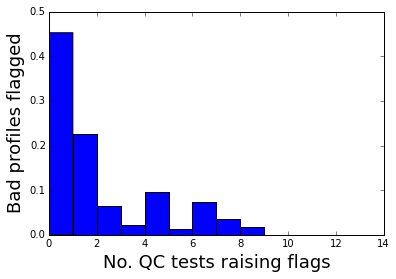

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

#load and arrange data
truth, rawResults = reloadData()
data = transpose(rawResults) #arrange data into rows by profile for consumption by scikit-learn

histEntries = []

for i in range(len(data)):
    if truth[i]:
        histEntries.append( sum(data[i]) )
        
plt.hist(histEntries, bins=range(15), normed=1 )
plt.xlabel('No. QC tests raising flags', fontsize=18)
plt.ylabel('Bad profiles flagged', fontsize=18)
plt.rcParams['figure.dpi'] = 300
plt.show()

Beyond the previous study, it is interesting to ask how important each of these QC tests are independently; here we reassess the 'all-or' results, omitting one QC test at a time:

In [28]:
truth, rawResults = reloadData()
data = transpose(rawResults)

for j in range(len(data[0])):
    TT = 0.
    TF = 0.
    FT = 0.
    FF = 0.
    for i in range(len(truth)):
        removeOne = data[i][:]
        del removeOne[j]
        anyFlag = sum(removeOne) > 0
        if anyFlag and truth[i]:
            TT += 1
        elif anyFlag and not truth[i]:
            TF += 1
        elif not anyFlag and truth[i]:
            FT += 1
        elif not anyFlag and not truth[i]:
            FF +=1
    printSummary('without ' + tests[j], TT/len(truth), TF/len(truth), FT/len(truth), FF/len(truth))
    print '         proportion of bad profiles correctly flagged: ', TT / (TT + FT), '\n'

without Argo_global_range_check
	 Correct flags: 0.0638564193418
	 False positive: 0.084724656101
	 False negative: 0.0528028654509
	 Correct pass: 0.798616059106
         proportion of bad profiles correctly flagged:  0.54737537141 

without Argo_gradient_test
	 Correct flags: 0.0638307432584
	 False positive: 0.0845834376424
	 False negative: 0.0528285415343
	 Correct pass: 0.798757277565
         proportion of bad profiles correctly flagged:  0.547155276769 

without Argo_impossible_date_test
	 Correct flags: 0.0638371622793
	 False positive: 0.0841276871626
	 False negative: 0.0528221225134
	 Correct pass: 0.799213028045
         proportion of bad profiles correctly flagged:  0.547210300429 

without Argo_impossible_location_test
	 Correct flags: 0.0638564193418
	 False positive: 0.084724656101
	 False negative: 0.0528028654509
	 Correct pass: 0.798616059106
         proportion of bad profiles correctly flagged:  0.54737537141 

without Argo_pressure_increasing_test
	 Correct flags

Once again, EN-background is the most important single test. It's standalone performance is:

In [33]:
truth, rawResults = reloadData()
data = transpose(rawResults)

TT = 0.
TF = 0.
FT = 0.
FF = 0.

for i in range(len(truth)):
    anyFlag = data[i][7]
    if anyFlag and truth[i]:
        TT += 1
    elif anyFlag and not truth[i]:
        TF += 1
    elif not anyFlag and truth[i]:
        FT += 1
    elif not anyFlag and not truth[i]:
        FF +=1
printSummary('EN-Background', TT/len(truth), TF/len(truth), FT/len(truth), FF/len(truth))
print 'correct flag rate:', TT / (TT + FT)
print 'correct pass rate:', FF / (FF + FT)

EN-Background
	 Correct flags: 0.0571806376655
	 False positive: 0.0430202776868
	 False negative: 0.0594786471272
	 Correct pass: 0.84032043752
correct flag rate: 0.490150764829
correct pass rate: 0.933897857708
